<a href="https://colab.research.google.com/github/Untick/Marketplaces/blob/Kosmylev-Vladislav-branch/4_%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Владислав Космылев

Стажировка "Маркетплейсы" *новички*

**Разветка боем с помощью Auto TS**

Проверка гипотиз
1. эксперименты с параметрами фреймворка
2. Эксперименты с составом датасетов

Этот ноутбук автономный. можно повторить все действия, установив настройки и запустив ячейки

## ПОДГОТОВКА

In [ ]:
!pip install jupyter
!pip install pyyaml==5.4.1
!pip install auto-ts --no-deps --ignore-installed
!pip install 'fsspec>=0.3.3'
!pip install statsmodels --upgrade
!pip install pmdarima

!pip3 install -q tscv

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd
import gdown
from sklearn.metrics import mean_absolute_error, mean_squared_error

from auto_ts import auto_timeseries
from auto_ts import print_ts_model_stats


In [ ]:
pd.options.display.width = 3000
pd.options.display.max_columns = 3000
pd.set_option('display.max_columns', 2000)

In [3]:
mpl.rcParams['figure.figsize'] = (20, 36)
mpl.rcParams['axes.grid'] = False

In [ ]:
!gdown --id '1D8hcRg9oNv2FDbEmffCyBBqyF9us47Jj' # df_svod.pkl

### НАСТРОЙКА

In [5]:
df_svod = pd.read_pickle("/content/df_svod.pkl")
category = df_svod['Категория_3го_уровня'].unique().tolist()

In [6]:
MIN_ROWS        = 300 # Минимальное количество строк в датасете для обучения моделей
START_DATE      = '2022-06-01' # С какой даты отбирать для разбивки на выборки
START_TEST_DATE = '2023-04-30' # С какой даты отрезать для тестовой выборки
TARGET          = 'Оборот_в_месяц_целевой' # или, например 'Заказано'
RESAMPLE        = 'M'

In [7]:
def get_dataset(cat):
  df = df_svod[(df_svod['Категория_3го_уровня'] == cat)].sort_values(by='День').copy(deep=True)
  # print('Отфильтровали')
  # display(df)
  t = df.groupby(['Категория_3го_уровня','День']).agg({'Посетители':'sum',
                                                  'Посетители_на_карточке_товара':'sum',
                                                  'Показы':'sum',
                                                  'Позиция_в_поиске_и_каталоге':'mean',
                                                  'В_корзину':'sum',
                                                  'Отменено':'sum',
                                                  'Доставлено':'sum',
                                                  'Возвращено':'sum',
                                                  'Акции':'mean',
                                                  'Заказано_по_Акции':'sum',
                                                  'Заказано_на_сумму_по_акции':'sum',
                                                  'Средний_чек':'mean',
                                                  'Контент_рейтинг':'mean',
                                                  'Текущая_цена':'mean',
                                                  'Трафареты_Охват':'sum',
                                                  'Трафареты_Клики':'sum',
                                                  'Трафареты_Расходы_всего':'sum',
                                                  'Трафареты_Количество_заказов':'sum',
                                                  'Трафареты_Сумма_заказов':'sum',
                                                  'Продвижение_в_поиске_Количество_заказов':'sum',
                                                  'Цена_продажи':'mean',
                                                  'Продвижение_в_поиске_Сумма_заказов':'sum',
                                                  'Ставка_%':'mean',
                                                  'Продвижение_в_поиске_Ставка':'mean',
                                                  'Контент_Количество_фотографий':'mean',
                                                  'Конкуренты_в_категории':'max',
                                                  'Заказано':'sum',
                                                  'Оборот_в_месяц_целевой':'sum',
                                                  })
  # print('Сгруппировали')
  # display(t)
  t = t.copy(deep=True)
  t = t.reset_index()
  t = t.copy(deep=True)
  t.drop('Категория_3го_уровня', axis=1, inplace=True)
  t['День'] = pd.to_datetime(t['День'])
  # print('Убрали лишнюю колонку')
  # display(t)
  t = t.copy(deep=True)
  # print('Датафрейм готов')
  return t

In [8]:
# Приготовим Датасеты для всех категорий
all_df = {}
for cat in category:
  try:
    df_cat = get_dataset(cat)
    if df_cat.shape[0] > MIN_ROWS:
      all_df[cat] = df_cat
  except:
    print(f'Что-то пошло не так с категорией: {cat}')

In [9]:
curent_df = np.nan
curent_cat = ''

def load_dataset(cat):
  t = all_df[cat]
  # t.set_index('День', inplace=True)
  # t = t.resample('M').mean()
  display(t)
  return t

def dataset_info(cat):
  df=curent_df
  fig = px.line(df.reset_index(), x = 'День', y = 'Оборот_в_месяц_целевой', title = cat)
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label='1M', step='month', stepmode='backward'),
              dict(count=3, label='3M', step='month', stepmode='backward'),
              dict(count=6, label='6M', step='month', stepmode='backward'),
              dict(step='all')
          ])
      )
  )
  fig.show()

  print(f'\n\n\n')
  print('Графики всех временных рядов из датасета:')
  print()
  df.plot(subplots=True)

def create_sets(df):
  t = df.reset_index()
  # train и test делю по датам
  train = t[(t['День'] >= START_DATE) & (t['День'] <= START_TEST_DATE)] #
  test = t[(t['День'] > START_TEST_DATE)]

  train.Оборот_в_месяц_целевой.plot(figsize=(15,8), title= 'Оборот', fontsize=14)
  test.Оборот_в_месяц_целевой.plot(figsize=(15,8), title= 'Оборот', fontsize=14)
  plt.show()
  return train, test

## ПРОБНОЕ Выявление оптимальных моделей на одной категории

In [10]:
category

['Лампа автомобильная',
 'Фара автомобильная',
 'Светодиодный модуль',
 'Комплектующие для ксеноновых фар',
 'Противотуманные фары',
 'Фонарь задний для авто',
 'Другое',
 'Автохимия - Герметик, клей',
 'Разное автопринадлежности',
 'Комплектующие светодиодной лампы для авто']

In [11]:
curent_cat = 'Фара автомобильная'

curent_df = load_dataset(curent_cat)
dataset_info(curent_cat)
# Создание выборок
train, test = create_sets(curent_df)

Основные параметры:


* `score_type (default = 'rmse')` метрика, используемая для оценки моделей среднеквадратическая ошибка (RMSE) или  «normalized_rmse»: отношение RMSE к стандартному отклонению фактических значений.


* `time_interval (default None)`  используется для указания частоты, с которой собираны данные. Используется для расчета сезонного периода для SARIMAX. Псевдонимы частоты H - час, D - день, M - месяц...

* `non_seasonal_pdq (default = (3,1,3))`  указывает максимальное значение (p, d, q), которое будет использоваться при поиске статистических моделей ARIMA. Если None, то предполагаются следующие значения: max_p = 3, max_d = 1, max_q = 3. Тип — Tuple.

* `seasonality (default = False)` В модели SARIMAX используется для указания, должна ли модель учитывать сезонные колебания данных или нет. Если параметр установлен в значение True, то модель будет учитывать сезонность, а если установлен в значение False (по умолчанию), то модель будет предполагать, что сезонности нет.

* `seasonal_period (default is None)` Параметр "сезонный период" указывает на периодичность пиков или впадин в ваших данных. Это значение используется только в модели SARIMAX при учете сезонности. Если значение параметра None, программа попытается определить его из временного интервала данных.


* `model_type (default: 'stats')`: доступные значения: 'best', 'prophet', 'stats', 'ARIMA', 'SARIMAX', 'VAR', 'ML'.

  'prophet' - создаст модель с использованием библиотеки Prophet.

  'stats' - создаст модели ARIMA, SARIMAX и VAR на основе библиотеки statsmodels.

  'ML' - создаст модель машинного обучения с использованием метода случайного леса, если указаны объясняющие переменные.

  'best' - попытается построить все модели и выбрать наилучшую.

In [15]:
model = auto_timeseries(score_type='rmse',
                time_interval='M', # Варианты частот: H - час, D - день, M - месяц
               # seasonality=True,
                model_type=['best'], # доступные значения: 'best', 'prophet', 'stats', 'ARIMA', 'SARIMAX', 'VAR', 'ML'.
                verbose=1)

In [ ]:
# бакапчик
model.fit(traindata=train[['Посетители', 'Посетители_на_карточке_товара', 'Показы',
       'Позиция_в_поиске_и_каталоге', 'В_корзину', 'Отменено', 'Доставлено',
       'Возвращено', 'Акции', 'Заказано_по_Акции',
       'Заказано_на_сумму_по_акции', 'Средний_чек', 'Контент_рейтинг',
       'Текущая_цена', 'Трафареты_Охват', 'Трафареты_Клики',
       'Трафареты_Расходы_всего', 'Трафареты_Количество_заказов',
       'Трафареты_Сумма_заказов', 'Продвижение_в_поиске_Количество_заказов',
       'Цена_продажи', 'Продвижение_в_поиске_Сумма_заказов', 'Ставка_%',
       'Продвижение_в_поиске_Ставка', 'Контент_Количество_фотографий',
       'Конкуренты_в_категории', 'Заказано', 'Оборот_в_месяц_целевой']], # столбцы участвующие в обработке

Start of Fit.....
    Target variable given as = Оборот_в_месяц_целевой
Start of loading of data.....
    Inputs: ts_column = День, sep = ,, target = ['Оборот_в_месяц_целевой']
    Using given input: pandas dataframe...
    День column exists in given train data...
    train data shape = (334, 27)
Alert: Could not detect strf_time_format of День. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is stationary after one differencing
There is 1 differencing needed in this datasets for VAR model


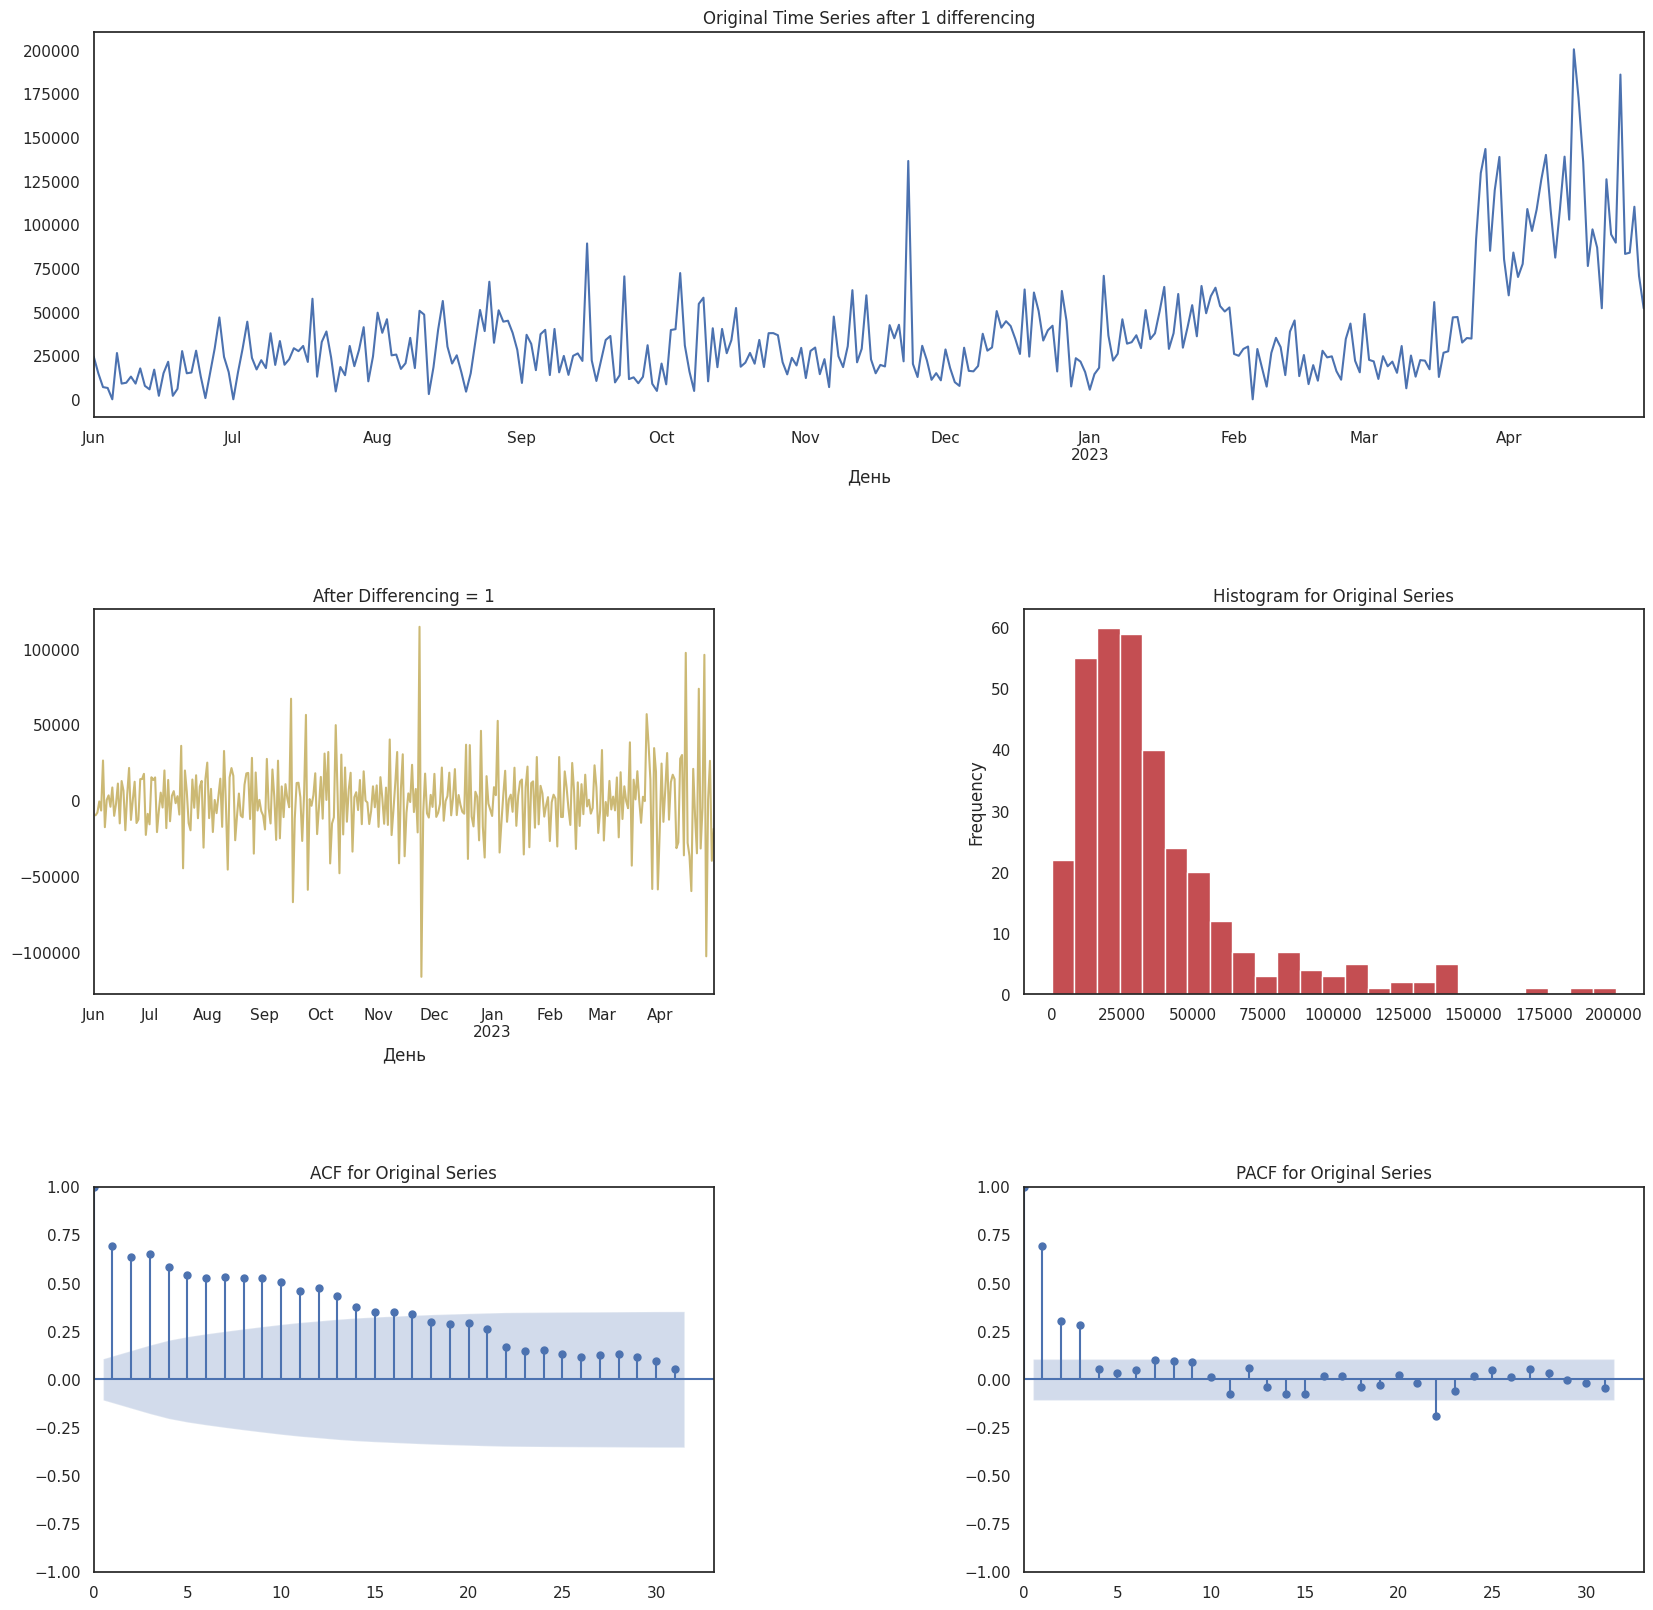

Time Interval is given as M
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(334, 28)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 309 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/v01d_3m8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/k3px9p4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66280', 'data', 'file=/tmp/tmpfc51gz6e/v01d_3m8.json', 'init=/tmp/tmpfc51gz6e/k3px9p4o.json', 'output', 'file=/tmp/tmpfc51gz6e/prophet_modelnv_yd3vq/prophet_model-20230830043102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
04:31:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/lbxftnzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/qulh9lgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

    RMSE = 64,039.48
    Std Deviation of actuals = 15,238.10
    Normalized RMSE (as pct of std dev) = 420%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 314 Test Shape: 5


INFO:cmdstanpy:Chain [1] start processing
04:31:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/affouzw4.json


    RMSE = 56,585.27
    Std Deviation of actuals = 41,350.90
    Normalized RMSE (as pct of std dev) = 137%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 319 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/izduicdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30252', 'data', 'file=/tmp/tmpfc51gz6e/affouzw4.json', 'init=/tmp/tmpfc51gz6e/izduicdp.json', 'output', 'file=/tmp/tmpfc51gz6e/prophet_modell4eg_3at/prophet_model-20230830043104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
04:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/5oh2azp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/9jxqacuv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin

    RMSE = 61,865.84
    Std Deviation of actuals = 35,630.34
    Normalized RMSE (as pct of std dev) = 174%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 324 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/kk8mggpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/zo2hx78v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32847', 'data', 'file=/tmp/tmpfc51gz6e/kk8mggpk.json', 'init=/tmp/tmpfc51gz6e/zo2hx78v.json', 'output', 'file=/tmp/tmpfc51gz6e/prophet_modely8biaxtg/prophet_model-20230830043105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
04:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 38,421.68
    Std Deviation of actuals = 44,783.26
    Normalized RMSE (as pct of std dev) = 86%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 329 Test Shape: 5
    RMSE = 86,227.77
    Std Deviation of actuals = 19,028.09
    Normalized RMSE (as pct of std dev) = 453%
Cross Validation window: 5 completed


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/hc44pc35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc51gz6e/kbh1j7ty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78233', 'data', 'file=/tmp/tmpfc51gz6e/hc44pc35.json', 'init=/tmp/tmpfc51gz6e/kbh1j7ty.json', 'output', 'file=/tmp/tmpfc51gz6e/prophet_modelpe8g1i0a/prophet_model-20230830043105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
04:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 53637.20
    MSE (Mean Squared Error = 4008356492.85
    MAPE (Mean Absolute Percent Error) = 57%
    RMSE (Root Mean Squared Error) = 63311.5826
    Normalized RMSE (MinMax) = 43%
    Normalized RMSE (as Std Dev of Actuals)= 168%
Time Taken = 3 seconds
  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 309 Test Shape: 5

    Finding the best parameters using AutoArima:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7040.121, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6981.296, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6925.564, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7038.170, Time=0

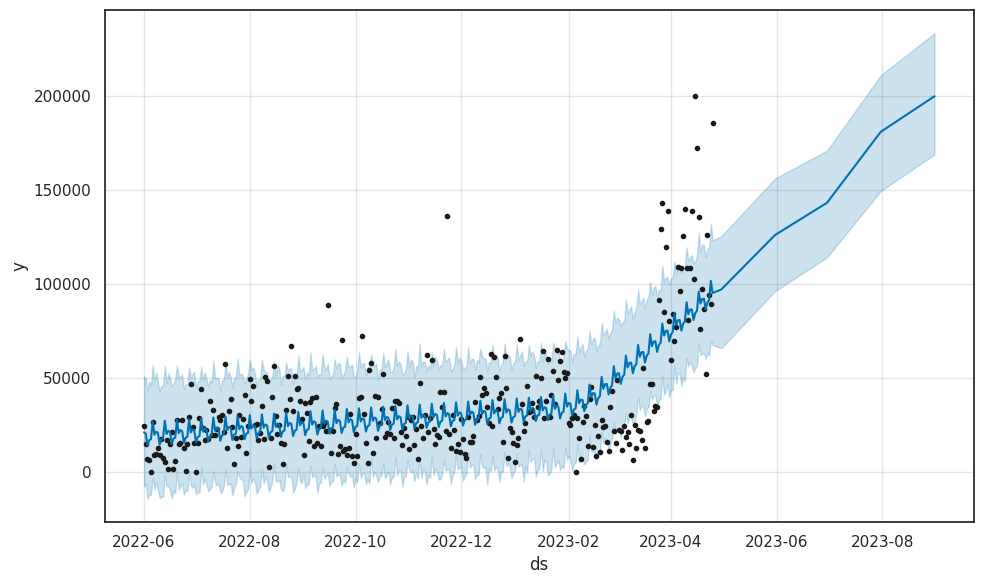

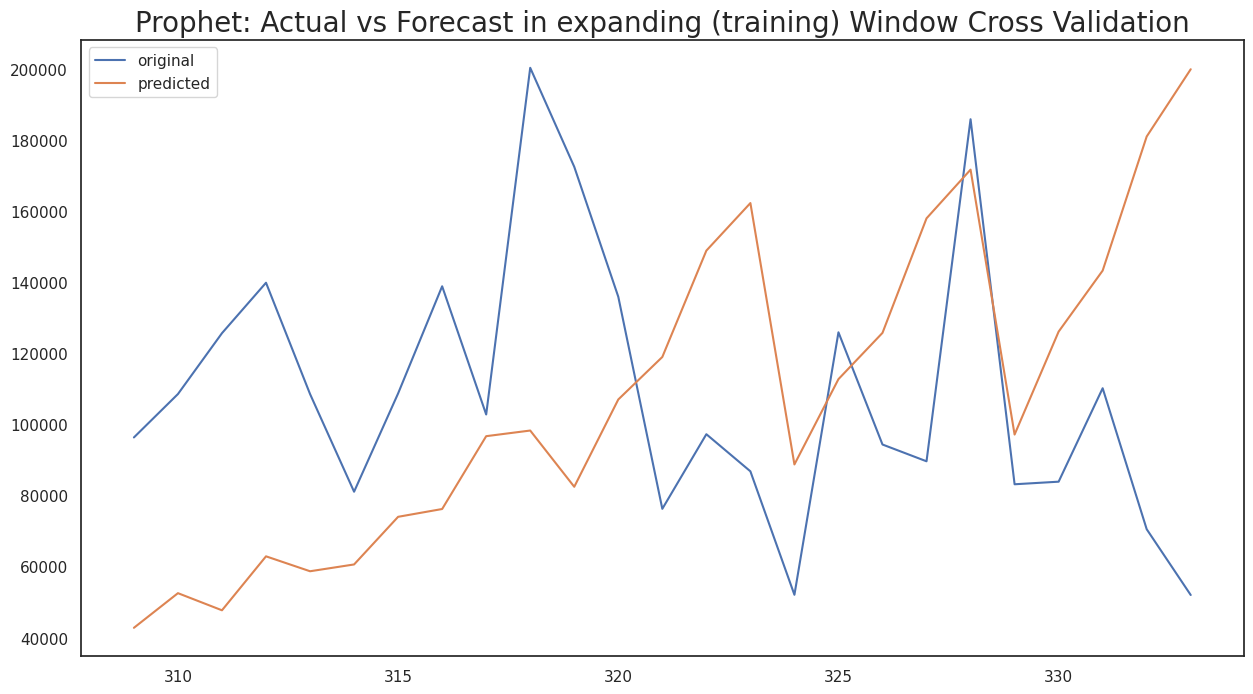

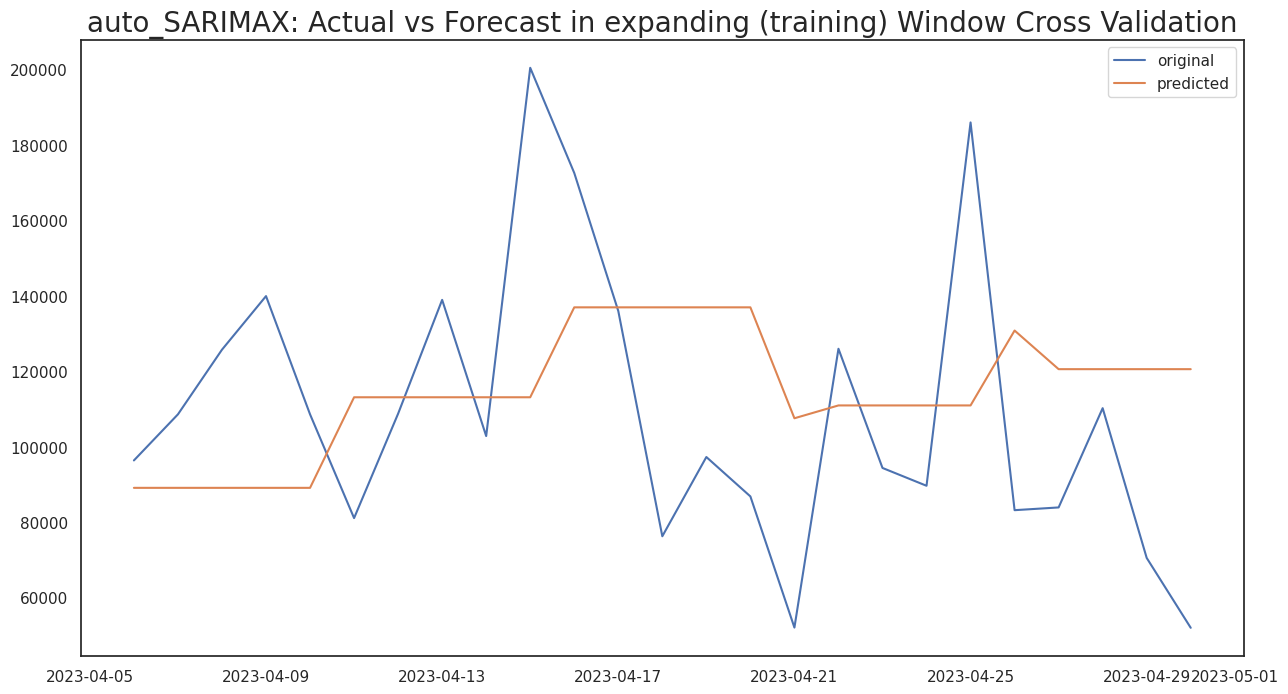

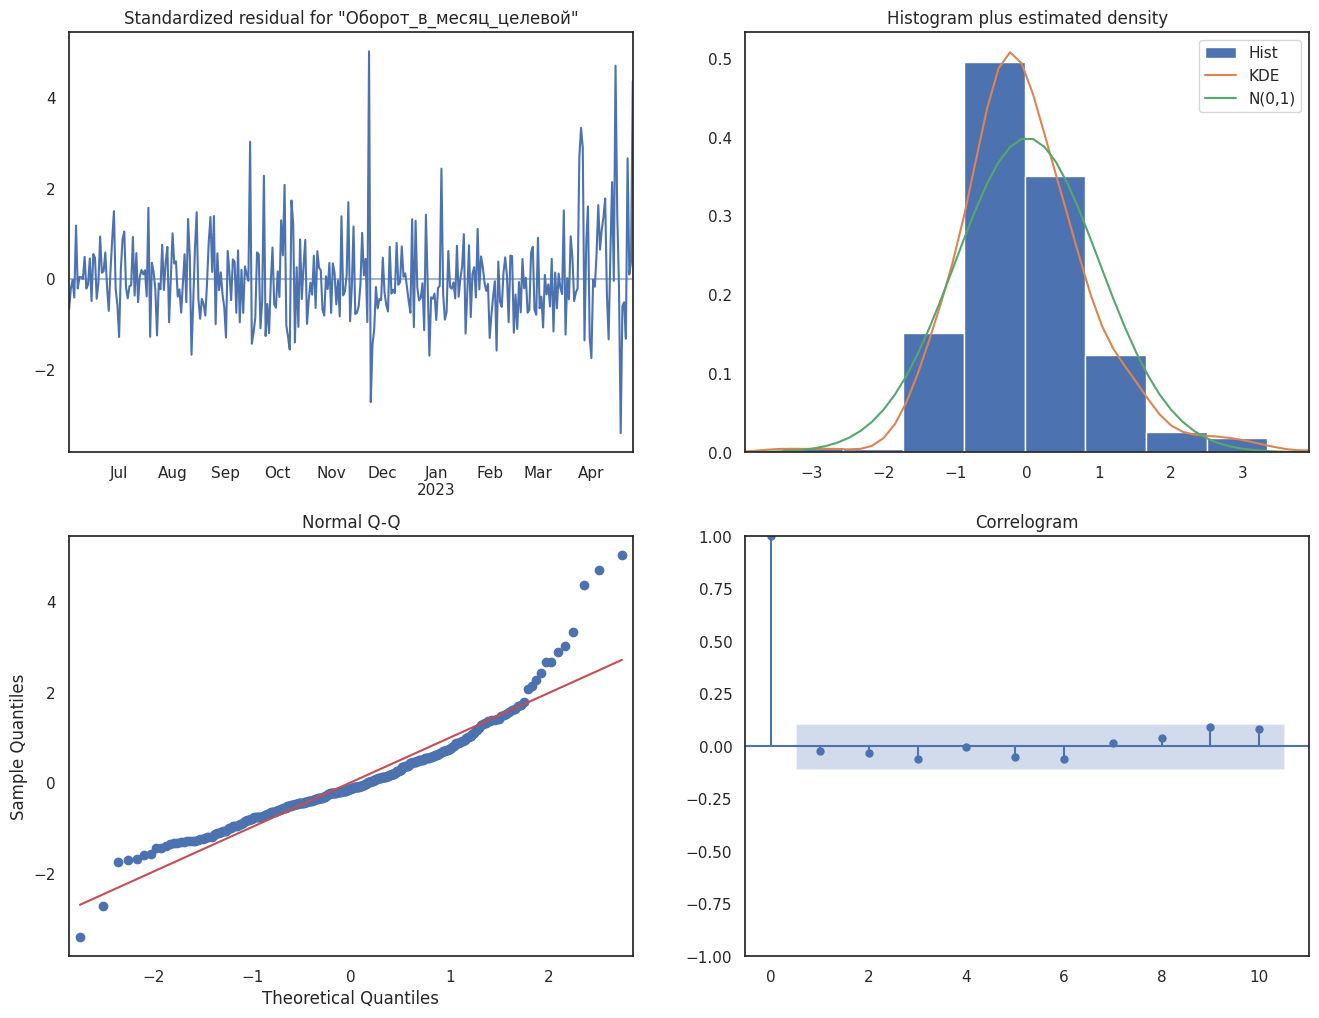

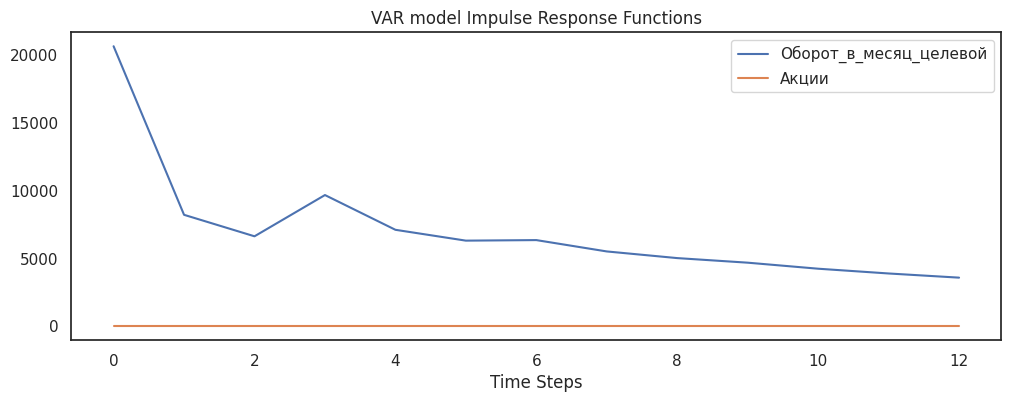

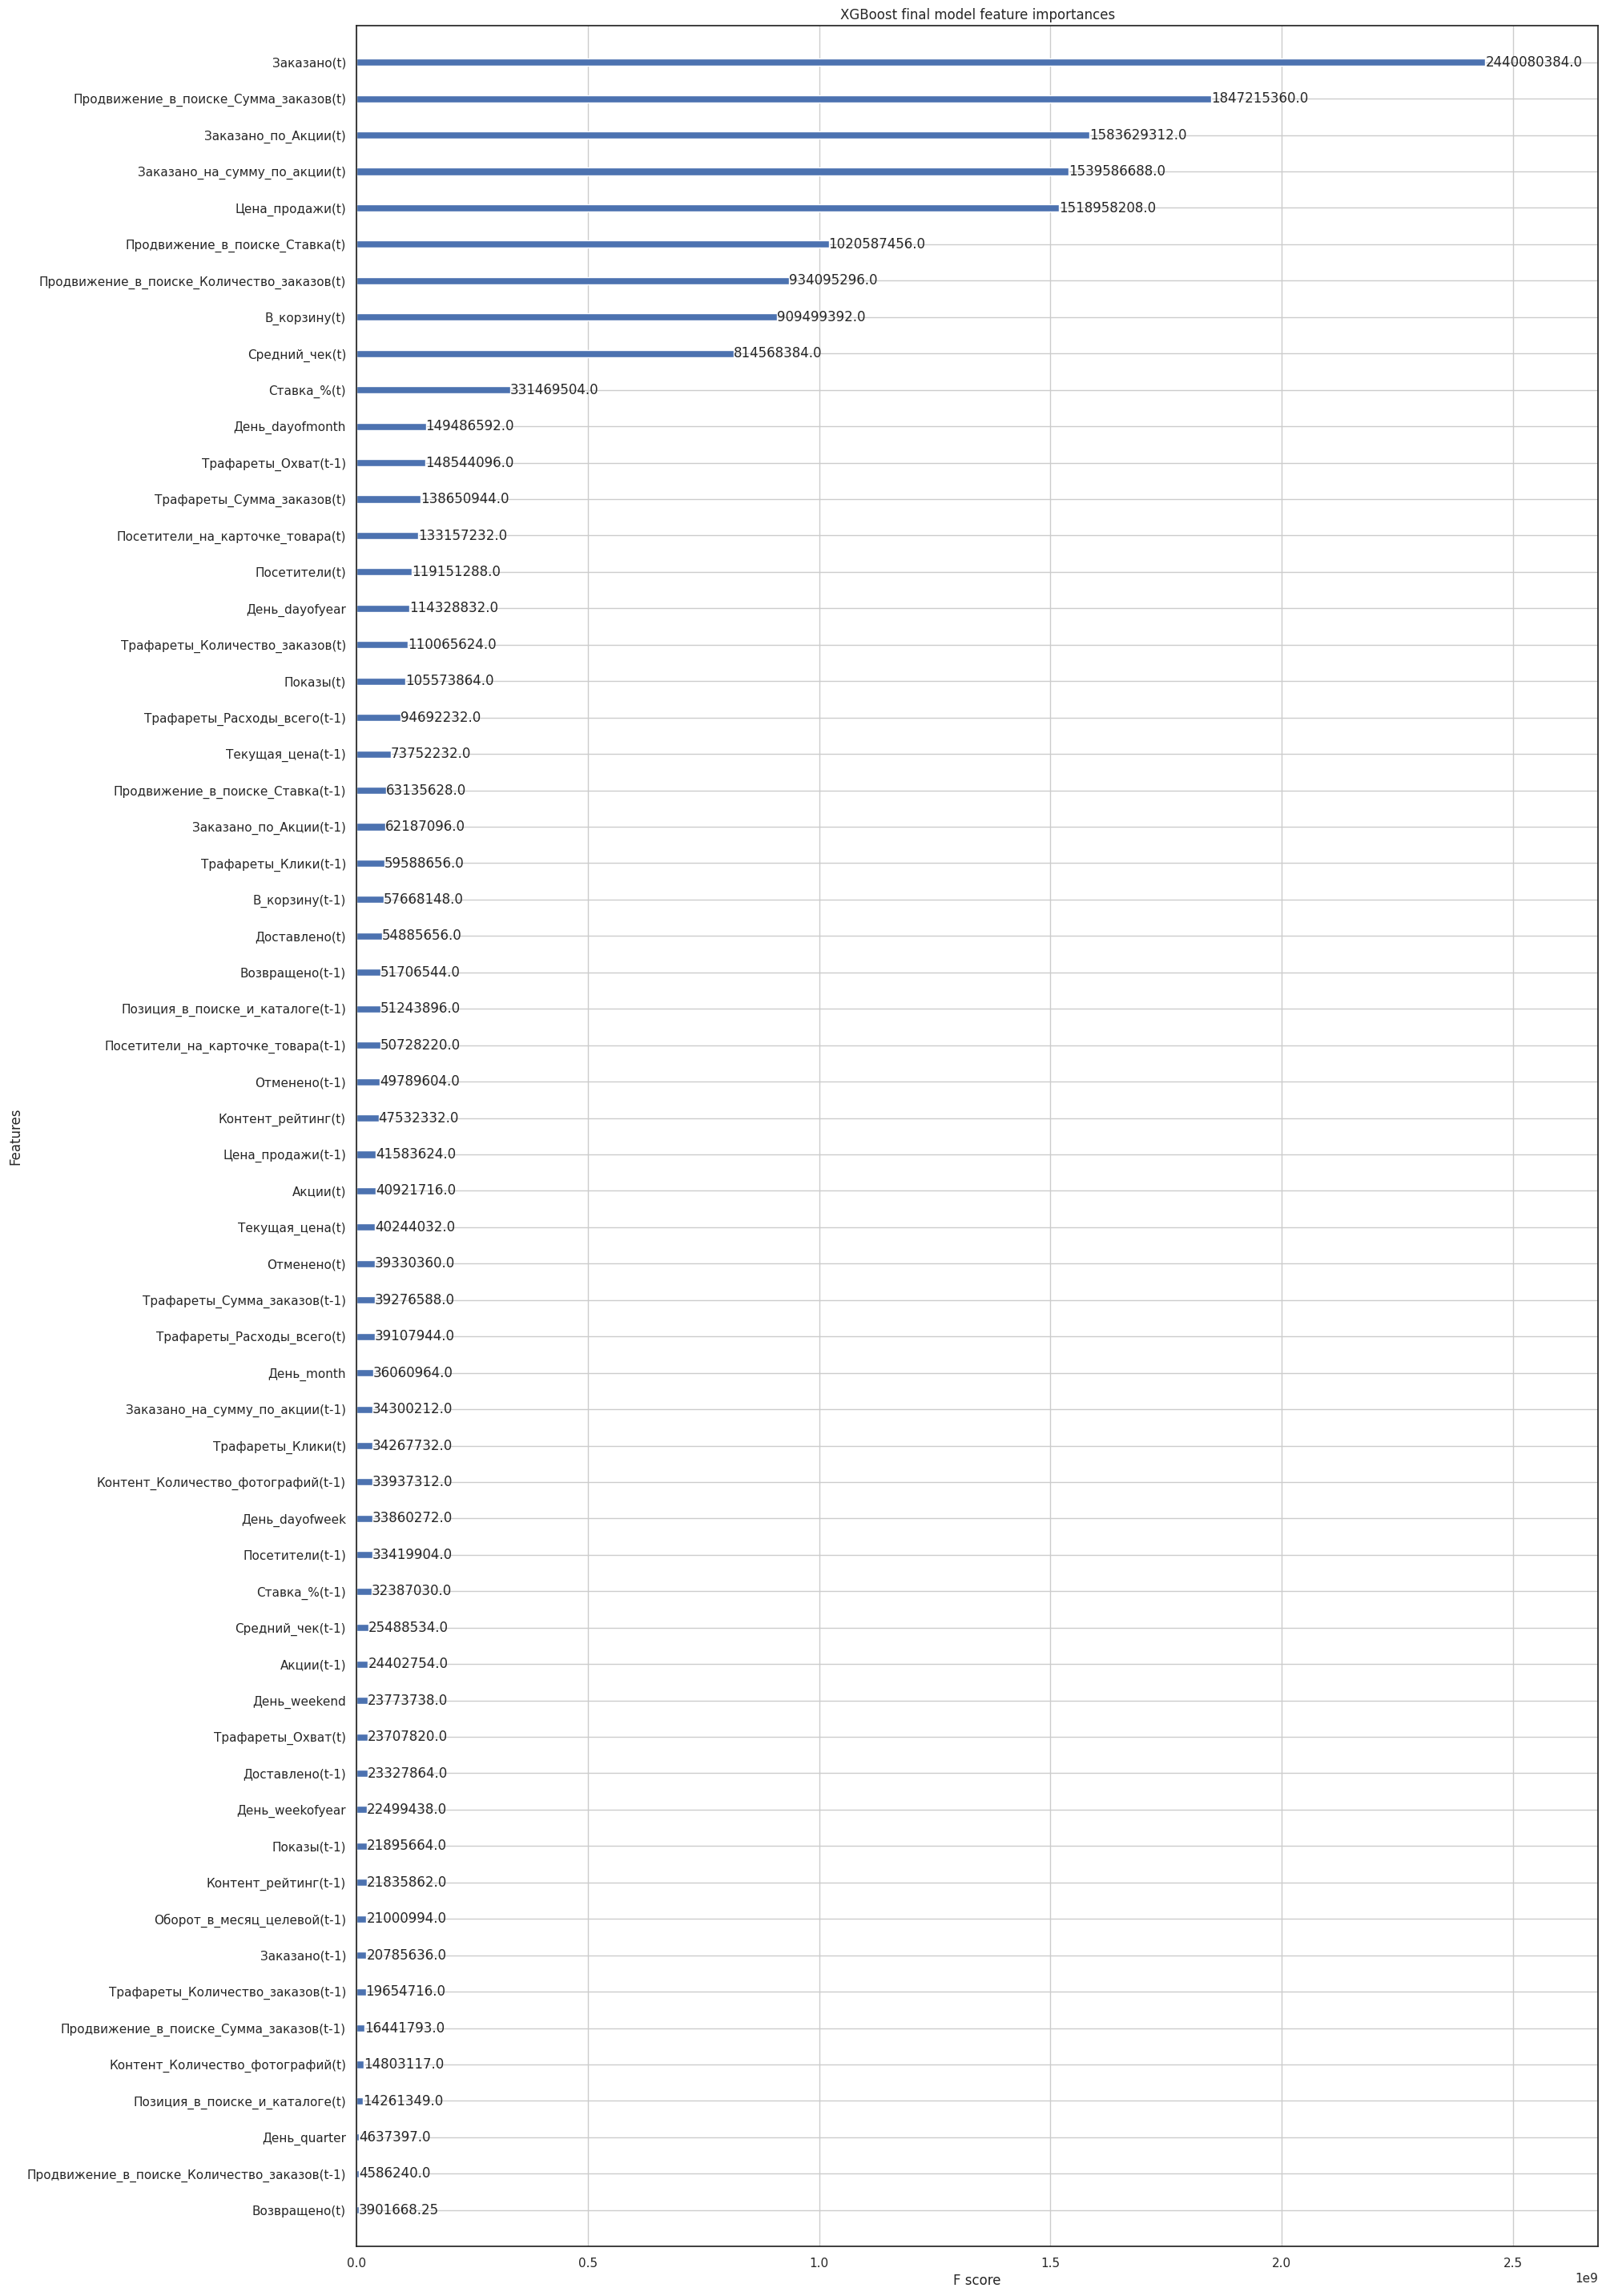

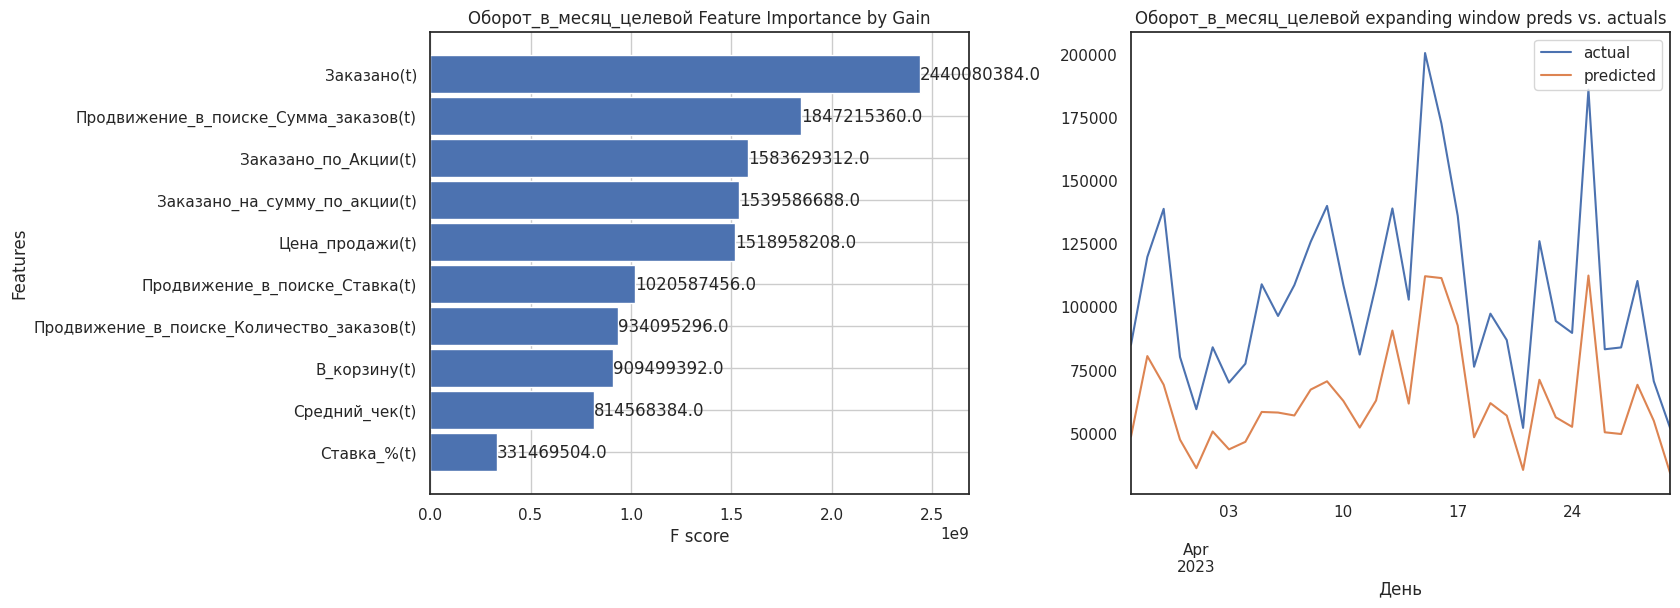

In [17]:
model.fit(traindata=train[['День','Посетители', 'Посетители_на_карточке_товара', 'Показы',
       'Позиция_в_поиске_и_каталоге', 'В_корзину', 'Отменено', 'Доставлено',
       'Возвращено', 'Акции', 'Заказано_по_Акции',
       'Заказано_на_сумму_по_акции', 'Средний_чек', 'Контент_рейтинг',
       'Текущая_цена', 'Трафареты_Охват', 'Трафареты_Клики',
       'Трафареты_Расходы_всего', 'Трафареты_Количество_заказов',
       'Трафареты_Сумма_заказов', 'Продвижение_в_поиске_Количество_заказов',
       'Цена_продажи', 'Продвижение_в_поиске_Сумма_заказов', 'Ставка_%',
       'Продвижение_в_поиске_Ставка', 'Контент_Количество_фотографий',
       'Заказано', 'Оборот_в_месяц_целевой']],
                          ts_column = 'День',
                          target = TARGET,
                          cv = 5)